<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_APGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 7.6 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
     |████████████████████████████████| 26.3 MB 1.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import TensorDataset, DataLoader

import cv2
from google.colab.patches import cv2_imshow

##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Def path

In [4]:
#scanner
scanner_name = 'HiScan'

#load modello
path_model = F"/content/gdrive/My Drive/Scanner/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

#predizioni testset originale
pd_preds=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}_con_normalize.xlsx'

##Collegamento google drive

In [5]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Transforms

In [6]:
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
transf_resize=transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST)

transf_load= transforms.Compose([transforms.ToTensor(),
                                 #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
trans_norm=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


#**Dataset**

##Caricamento dataset

In [7]:
test_dataset = datasets.ImageFolder(pathTestset,transform=transf_load)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [8]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)

##Nomi classi

In [9]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


##Min Max dataset

In [10]:
a,_=next(iter(testgen))
_min,_max=torch.min(a),torch.max(a)
print(_min,_max)

tensor(0.) tensor(1.)


#**Riduzione dataset**

In [11]:
test_dataset.samples=test_dataset.samples[1004:1005]

dim_set=len(test_dataset)
print(dim_set)

1


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [12]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [13]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [14]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [15]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Perturbazione

In [16]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni
  '''
  if x_adv.shape[2]!=1000:
    x=np.array(transf_resize(torch.Tensor(x)))
  perturb=x_adv-x
  
  if perturb.shape[2]!=1000:
    perturb=np.array(transf_init(torch.Tensor(perturb)))
  
  return perturb

##Print subplot

In [17]:
def print_subplot(perturb,x_test,y_test,preds,x_test_adv,value_preds_adv):
  '''
    perturb: perturbazioni
    x_test: img originali
    y_test: classi originali
    preds: classi predette per img originali
    x_test_adv: img contraddittoria
    value_preds_adv: probabilità predette img contraddittorie
    normalize: se True normalizza le immagini
  '''

  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(len(x_test)):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(classes_name[ind[0][0]]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    val_pert=np.mean(np.abs(perturb[i]))
    pert_min,pert_max=np.min(perturb[i]),np.max(perturb[i])
    #perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)
    perturb[i]=np.clip(perturb[i],0,1) #rimuovo i valori negativi poiché non posso visualizzarli
    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[20,20])
    #plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+classes_name[np.argmax(y_test[i])]+"\nclasse predetta: "+str(classes_name[preds[i]]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb[i].transpose(1,2,0),cmap='gray')
    #ax2.imshow(perturb[i],cmap='gray')
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE\nvalore medio: "+str(round(val_pert,4))+"\nmin: "+str(pert_min)+"\nmax: "+str(pert_max))
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

##Testing

In [18]:
def test_average(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities, values
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax(dim=0)
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  values=[live,spoof]
  predicted=np.argmax(values)
  probabilities=prob(torch.Tensor(values)).numpy()

  return predicted,probabilities,values

##mask

In [19]:
def compute_mask(img):
  #img iniziale [0,1]
  img=np.array(img[0])
  img=img.transpose(1,2,0)

  #trasforma in gray
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  #scala in [0,255]
  gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
  gray=gray*255
  gray=gray.astype('uint8')
  #calcola immagine binaria
  ret, imgf = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  image_contours = np.zeros((imgf.shape[1],
                            imgf.shape[0]),
                            np.uint8)

  image_binary = np.zeros((imgf.shape[1],
                          imgf.shape[0]),
                          np.uint8)

  #cerca i contorni nell'immagine binaria
  contours =cv2.findContours(imgf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  cv2.drawContours(image_contours,
                      contours, -1,
                      (255,255), 3)

  contours = cv2.findContours(image_contours, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[0]
  #disegna solo il contorno più esterno
  cv2.drawContours(image_binary, [max(contours, key = cv2.contourArea)],
                  -1, (255, 255),-1)
  #restituisce immagine [0,1]
  return ((image_binary-np.min(image_binary))/(np.max(image_binary)-np.min(image_binary)))

##Save/read

In [20]:
def save_read(x):
  print("valori img originale:")
  print(test_average(classifier,torch.Tensor(x).unsqueeze_(0)))
  x=x.transpose(1,2,0)*255
  #plt.imsave('prova.bmp',x)
  cv2.imwrite('prova.png',x)
  #plt.imshow(x)
  #cv2_imshow(x)

  x=cv2.imread('prova.png')
  x=x/255
  #x=plt.imread('prova.png')/255
  #plt.imshow(prova_arr*255)
  #cv2_imshow(x*255)
  print("valori dopo salvataggio/lettura:")
  print(test_average(classifier,torch.Tensor(x.transpose(2,0,1)).unsqueeze_(0)))

##accuracy single class

In [21]:
def accuracy_class(class_str,pd_class):
  '''
  class_str: string class
  pd_class: dataframe
  '''
  n=np.sum(pd_class['real']==class_str)
  print("# img"+class_str+": "+str(n))

  p=pd_class.loc[pd_class['real']==class_str]
  p=p.loc[p['predicted']==p['real']]
  n_class=p.count(0)[0]
  print("Numero di predizioni "+class_str+" giuste: "+str(n_class))
  print("Accuracy : "+str(round(n_class/n*100,2)))  

##print accuracy

In [22]:
def print_acc(pd_preds):
  '''
  stampa accuracy usando il dataframe con le predizioni
  pd_preds: dataframe
  '''
  true_label = pd_preds.real.values
  predicted = pd_preds.predicted.values
  accuracy=round((np.sum((true_label == predicted).astype(int)))/pd_preds.shape[0],4)*100
  print("\nAccuracy: {0}".format(accuracy))
  print("Shape dataframe: {0}".format(pd_preds.shape)) 

##APGD mod

In [30]:
import logging
import math
from typing import Optional, Union, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import check_and_transform_label_format, projection, random_sphere, is_probability, get_labels_np_array

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class AutoProjectedGradientDescent_mod(EvasionAttack):
    """
    Implementation of the `Auto Projected Gradient Descent` attack.
    | Paper link: https://arxiv.org/abs/2003.01690
    """

    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "max_iter",
        "targeted",
        "nb_random_init",
        "class_target",
        "confidence",        
        "batch_size",
        "loss_type",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin, ClassifierMixin)
    _predefined_losses = [None, "cross_entropy", "difference_logits_ratio"]

    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: float = 0.3,
        eps_step: float = 0.1,
        max_iter: int = 100,
        targeted: bool = False,
        nb_random_init: int = 5,
        class_target = 0,
        confidence = 0.7,        
        batch_size: int = 32,
        loss_type: Optional[str] = None,
        verbose: bool = True,
    ):
        """
        Create a :class:`.AutoProjectedGradientDescent` instance.
        :param estimator: An trained estimator.
        :param norm: The norm of the adversarial perturbation. Possible values: "inf", np.inf, 1 or 2.
        :param eps: Maximum perturbation that the attacker can introduce.
        :param eps_step: Attack step size (input variation) at each iteration.
        :param max_iter: The maximum number of iterations.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False).
        :param nb_random_init: Number of random initialisations within the epsilon ball. For num_random_init=0
            starting at the original input.
        :param class_target: classe da far predire.
        :param confidence: probabilità minima con la quale predire class_target.            
        :param batch_size: Size of the batch on which adversarial samples are generated.
        :param loss_type: Defines the loss to attack. Available options: None (Use loss defined by estimator),
            "cross_entropy", or "difference_logits_ratio"
        :param verbose: Show progress bars.
        """
        from art.estimators.classification import TensorFlowClassifier, TensorFlowV2Classifier, PyTorchClassifier

        if loss_type not in self._predefined_losses:
            raise ValueError(
                "The argument loss_type has an invalid value. The following options for `loss_type` are currently "
                "supported: {}".format(self._predefined_losses)
            )

        if loss_type is None:
            if hasattr(estimator, "predict") and is_probability(
                estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=np.float32))
            ):
                raise ValueError(
                    "AutoProjectedGradientDescent is expecting logits as estimator output, the provided "
                    "estimator seems to predict probabilities."
                )

            estimator_apgd = estimator
        else:
            if isinstance(estimator, TensorFlowClassifier):
                import tensorflow as tf

                if loss_type == "cross_entropy":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise NotImplementedError("Cross-entropy loss is not implemented for probability output.")

                    self._loss_object = tf.reduce_mean(
                        tf.keras.losses.categorical_crossentropy(
                            y_pred=estimator._output, y_true=estimator._labels_ph, from_logits=True
                        )
                    )

                elif loss_type == "difference_logits_ratio":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    raise ValueError(
                        "The loss `difference_logits_ratio` has not been validate completely. It seems that the "
                        "commented implemented below is failing to selected the second largest logit for cases "
                        "where the largest logit is the true logit. For future work `difference_logits_ratio` and "
                        "loss_fn should return the same loss value."
                    )

                    # def difference_logits_ratio(y_true, y_pred):
                    #     i_y_true = tf.cast(tf.math.argmax(tf.cast(y_true, tf.int32), axis=1), tf.int32)
                    #     i_y_pred_arg = tf.argsort(y_pred, axis=1)
                    #     # Not completely sure if the following line is correct.
                    #     # `i_y_pred_arg[:, -2], i_y_pred_arg[:, -1]` seems closer to the output of `loss_fn` than
                    #     # `i_y_pred_arg[:, -1], i_y_pred_arg[:, -2]`
                    #     i_z_i = tf.where(i_y_pred_arg[:, -1] != i_y_true[:], i_y_pred_arg[:, -2],
                    #                      i_y_pred_arg[:, -1])
                    #
                    #     z_1 = tf.gather(y_pred, i_y_pred_arg[:, -1], axis=1, batch_dims=0)
                    #     z_3 = tf.gather(y_pred, i_y_pred_arg[:, -3], axis=1, batch_dims=0)
                    #     z_i = tf.gather(y_pred, i_z_i, axis=1, batch_dims=0)
                    #     z_y = tf.gather(y_pred, i_y_true, axis=1, batch_dims=0)
                    #
                    #     z_1 = tf.linalg.diag_part(z_1)
                    #     z_3 = tf.linalg.diag_part(z_3)
                    #     z_i = tf.linalg.diag_part(z_i)
                    #     z_y = tf.linalg.diag_part(z_y)
                    #
                    #     dlr = -(z_y - z_i) / (z_1 - z_3)
                    #
                    #     return tf.reduce_mean(dlr)
                    #
                    # def loss_fn(y_true, y_pred):
                    #     i_y_true = np.argmax(y_true, axis=1)
                    #     i_y_pred_arg = np.argsort(y_pred, axis=1)
                    #     i_z_i = np.where(i_y_pred_arg[:, -1] != i_y_true[:], i_y_pred_arg[:, -1],
                    #                      i_y_pred_arg[:, -2])
                    #
                    #     z_1 = y_pred[:, i_y_pred_arg[:, -1]]
                    #     z_3 = y_pred[:, i_y_pred_arg[:, -3]]
                    #     z_i = y_pred[:, i_z_i]
                    #     z_y = y_pred[:, i_y_true]
                    #
                    #     z_1 = np.diag(z_1)
                    #     z_3 = np.diag(z_3)
                    #     z_i = np.diag(z_i)
                    #     z_y = np.diag(z_y)
                    #
                    #     dlr = -(z_y - z_i) / (z_1 - z_3)
                    #
                    #     return np.mean(dlr)
                    #
                    # self._loss_fn = loss_fn
                    # self._loss_object = difference_logits_ratio(y_true=estimator._labels_ph,
                    #                                             y_pred=estimator._output)

                estimator_apgd = TensorFlowClassifier(
                    input_ph=estimator._input_ph,
                    output=estimator._output,
                    labels_ph=estimator._labels_ph,
                    train=estimator._train,
                    loss=self._loss_object,
                    learning=estimator._learning,
                    sess=estimator._sess,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                    feed_dict=estimator._feed_dict,
                )

            elif isinstance(estimator, TensorFlowV2Classifier):
                import tensorflow as tf

                if loss_type == "cross_entropy":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        self._loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
                    else:
                        self._loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                elif loss_type == "difference_logits_ratio":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    class DifferenceLogitsRatioTensorFlowV2:
                        """
                        Callable class for Difference Logits Ratio loss in TensorFlow v2.
                        """

                        def __init__(self):
                            self.reduction = "mean"

                        def __call__(self, y_true, y_pred):
                            i_y_true = tf.cast(tf.math.argmax(tf.cast(y_true, tf.int32), axis=1), tf.int32)
                            i_y_pred_arg = tf.argsort(y_pred, axis=1)
                            i_z_i_list = list()

                            for i in range(y_true.shape[0]):
                                if i_y_pred_arg[i, -1] != i_y_true[i]:
                                    i_z_i_list.append(i_y_pred_arg[i, -1])
                                else:
                                    i_z_i_list.append(i_y_pred_arg[i, -2])

                            i_z_i = tf.stack(i_z_i_list)

                            z_1 = tf.gather(y_pred, i_y_pred_arg[:, -1], axis=1, batch_dims=0)
                            z_3 = tf.gather(y_pred, i_y_pred_arg[:, -3], axis=1, batch_dims=0)
                            z_i = tf.gather(y_pred, i_z_i, axis=1, batch_dims=0)
                            z_y = tf.gather(y_pred, i_y_true, axis=1, batch_dims=0)

                            z_1 = tf.linalg.diag_part(z_1)
                            z_3 = tf.linalg.diag_part(z_3)
                            z_i = tf.linalg.diag_part(z_i)
                            z_y = tf.linalg.diag_part(z_y)

                            dlr = -(z_y - z_i) / (z_1 - z_3)

                            return tf.reduce_mean(dlr)

                    self._loss_fn = DifferenceLogitsRatioTensorFlowV2()
                    self._loss_object = DifferenceLogitsRatioTensorFlowV2()

                estimator_apgd = TensorFlowV2Classifier(
                    model=estimator.model,
                    nb_classes=estimator.nb_classes,
                    input_shape=estimator.input_shape,
                    loss_object=self._loss_object,
                    train_step=estimator._train_step,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                )
            elif isinstance(estimator, PyTorchClassifier):
                import torch

                if loss_type == "cross_entropy":
                    if is_probability(
                        estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=np.float32))
                    ):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. If loss_type='cross_entropy' "
                            "the estimator has to to predict logits."
                        )

                    self._loss_object = torch.nn.CrossEntropyLoss(reduction="mean")
                elif loss_type == "difference_logits_ratio":
                    if is_probability(
                        estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=ART_NUMPY_DTYPE))
                    ):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    class DifferenceLogitsRatioPyTorch:
                        """
                        Callable class for Difference Logits Ratio loss in PyTorch.
                        """

                        def __init__(self):
                            self.reduction = "mean"

                        def __call__(self, y_pred, y_true):  # type: ignore
                            if isinstance(y_true, np.ndarray):
                                y_true = torch.from_numpy(y_true)
                            if isinstance(y_pred, np.ndarray):
                                y_pred = torch.from_numpy(y_pred)

                            y_true = y_true.float()

                            i_y_true = torch.argmax(y_true, axis=1)
                            i_y_pred_arg = torch.argsort(y_pred, axis=1)
                            i_z_i_list = list()

                            for i in range(y_true.shape[0]):
                                if i_y_pred_arg[i, -1] != i_y_true[i]:
                                    i_z_i_list.append(i_y_pred_arg[i, -1])
                                else:
                                    i_z_i_list.append(i_y_pred_arg[i, -2])

                            i_z_i = torch.stack(i_z_i_list)

                            z_1 = y_pred[:, i_y_pred_arg[:, -1]]
                            z_3 = y_pred[:, i_y_pred_arg[:, -3]]
                            z_i = y_pred[:, i_z_i]
                            z_y = y_pred[:, i_y_true]

                            z_1 = torch.diagonal(z_1)
                            z_3 = torch.diagonal(z_3)
                            z_i = torch.diagonal(z_i)
                            z_y = torch.diagonal(z_y)

                            dlr = -(z_y - z_i) / (z_1 - z_3)

                            return torch.mean(dlr.float())

                    self._loss_object = DifferenceLogitsRatioPyTorch()

                estimator_apgd = PyTorchClassifier(
                    model=estimator.model,
                    loss=self._loss_object,
                    input_shape=estimator.input_shape,
                    nb_classes=estimator.nb_classes,
                    optimizer=None,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                    device_type=str(estimator._device),
                )

            else:
                raise ValueError("The loss type {} is not supported for the provided estimator.".format(loss_type))

        super().__init__(estimator=estimator_apgd)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self.max_iter = max_iter
        self.targeted = targeted
        self.nb_random_init = nb_random_init
        self.class_target=class_target
        self.confidence=confidence        
        self.batch_size = batch_size
        self.loss_type = loss_type
        self.verbose = verbose
        self._check_params()

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape `(nb_samples, nb_classes)` or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param mask: An array with a mask broadcastable to input `x` defining where to apply adversarial perturbations.
                     Shape needs to be broadcastable to the shape of x and can also be of the same shape as `x`. Any
                     features for which the mask is zero will not be adversarially perturbed.
        :type mask: `np.ndarray`
        :return: An array holding the adversarial examples.
        """
        mask = kwargs.get("mask")

        y = check_and_transform_label_format(y, self.estimator.nb_classes)

        if y is None:
            if self.targeted:
                raise ValueError("Target labels `y` need to be provided for a targeted attack.")
            y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size)).astype(np.int32)

        if self.estimator.nb_classes == 2 and y.shape[1] == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        x_adv = x.astype(ART_NUMPY_DTYPE)
        
        #questo for serve per i riavvi random, quindi se l'immagine non è spoof spoof è inutile
        for t in trange(max(1, self.nb_random_init), desc="AutoPGD - restart", disable=not self.verbose):
            # Determine correctly predicted samples
            #y_pred = self.estimator.predict(x_adv)
            
            pred,value,_=test_average(self.estimator,torch.Tensor(x_adv)) #preds è già la classe finale mentre y_pred contiene i due valori
            
            if self.targeted:
                sample_is_robust = np.argmax(y_pred, axis=1) != np.argmax(y, axis=1)
            elif not self.targeted:
                #sample_is_robust = np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)
                
                #mod
                if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                  sample_is_robust=True
                elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(value)<self.confidence)):  
                  sample_is_robust=True
                else:  sample_is_robust=False

                #print("preds=label e preds=spoof")
              
              
                #print("preds=label, preds=live e confidence<0.6")
                
              

            #sample_is_robust è vettore di booleani, indica se l'attacco deve essere eseguito (True), ovvero se il modello predice bene
            
            #print("y: "+str(y))
            #print("pred: "+str(preds))
            #print("sampleisrobust: "+str(sample_is_robust))
            
            if sample_is_robust == False:
                #vedi se questo break blocca il for esterno, se non lo blocca è inutile, ma dovrebbe farlo
                break
            
            #recap: se non è spoof spoof uso break per uscire dal for e restituisco l'immagine originale, altrimenti continuo e faccio resize dell'immagine
            if t==0:
              x_adv=transf_resize(torch.Tensor(x_adv))
              mask_mod=compute_mask(x_adv)
              x_adv=np.array(x_adv)

            x_robust = x_adv
            y_robust = y
            x_init = np.array(transf_resize(torch.Tensor(x)))
            #print("x_robust inizio")
            #cv2_imshow(x_robust[0].transpose(1,2,0)*255)
           
            if self.nb_random_init!=0:
              n = x_robust.shape[0] #numero di immagini (1)
              m = np.prod(x_robust.shape[1:]).item()
              random_perturbation = (
                  random_sphere(n, m, self.eps, self.norm).reshape(x_robust.shape).astype(ART_NUMPY_DTYPE)
              )*(mask_mod.astype(ART_NUMPY_DTYPE))
              #dovresti trasformare random_pert in gray e applicare anche la maschera
              random_perturbation = 0.2989 * random_perturbation[0,0,:,:] + 0.5870 * random_perturbation[0,1,:,:] + 0.1140 * random_perturbation[0,2,:,:]
              for i in range(3):
                x_robust[0,i,:,:] = x_robust[0,i,:,:] + random_perturbation
              #x_robust = x_robust + random_perturbation #applica una perturbazione random, penso per generare un nuovo x di partenza diverso da x_init

              #effettua clipping dei valori
              if self.estimator.clip_values is not None:
                  clip_min, clip_max = self.estimator.clip_values
                  x_robust = np.clip(x_robust, clip_min, clip_max)
              #print("x_robust dopo random_perturbation")
              #cv2_imshow(x_robust[0].transpose(1,2,0)*255)
              #aggiusta la perturbazione con projection, infatti le passa x_robust-x_init che sarebbe la perturbazione totale applicata da x_init nelle varie iterazioni
              perturbation = projection(x_robust - x_init, self.eps, self.norm)#*(mask_mod.astype(ART_NUMPY_DTYPE))
              perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
              for i in range(3):
                x_robust[0,i,:,:] = x_init[0,i,:,:] + perturbation
              #somma la perturbazione aggiustata a x_init per generare un nuovo x_robust e ricominciare
              #x_robust = x_init + perturbation
              #print("x_robust dopo perturbazione proiettata")
              #cv2_imshow(x_robust[0].transpose(1,2,0)*255)
            # Compute perturbation with implicit batching
            #for per ogni batch (viene eseguito una volta)
            for batch_id in trange(
                int(np.ceil(x_robust.shape[0] / float(self.batch_size))),
                desc="AutoPGD - batch",
                leave=False,
                disable=not self.verbose,
            ):
                self.eta = 2 * self.eps_step
                batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
                x_k = x_robust[batch_index_1:batch_index_2].astype(ART_NUMPY_DTYPE)
                x_init_batch = x_init[batch_index_1:batch_index_2].astype(ART_NUMPY_DTYPE)
                y_batch = y_robust[batch_index_1:batch_index_2]

                p_0 = 0
                p_1 = 0.22
                var_w = [p_0, p_1]

                while True:
                    p_j_p_1 = var_w[-1] + max(var_w[-1] - var_w[-2] - 0.03, 0.06)
                    if p_j_p_1 > 1:
                        break
                    var_w.append(p_j_p_1)

                var_w = [math.ceil(p * self.max_iter) for p in var_w]

                eta = self.eps_step
                self.count_condition_1 = 0
                
                #for per ogni iterazione fino a max_iter
                for k_iter in trange(self.max_iter, desc="AutoPGD - iteration", leave=False, disable=not self.verbose):
                    # Get perturbation, use small scalar to avoid division by 0
                    tol = 10e-8

                    # Get gradient wrt loss; invert it if attack is targeted
                    grad = self.estimator.loss_gradient(np.array(trans_norm(torch.Tensor(x_k))), y_batch) * (1 - 2 * int(self.targeted))

                    # Apply norm bound
                    if self.norm in [np.inf, "inf"]:
                        grad = np.sign(grad)
                    elif self.norm == 1:
                        ind = tuple(range(1, len(x_k.shape)))
                        grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
                    elif self.norm == 2:
                        ind = tuple(range(1, len(x_k.shape)))
                        grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
                    assert x_k.shape == grad.shape
                    #calcola la perturbazione in maniera simile a FGM
                    perturbation = grad
                    
                    #applica la maschera alla perturbazione
                    #if mask is not None:
                    #    perturbation = perturbation * (mask.astype(ART_NUMPY_DTYPE))
                    #print("pert prima mask")
                    #cv2_imshow(perturbation[0].transpose(1,2,0)*255)
                    perturbation = perturbation * (mask_mod.astype(ART_NUMPY_DTYPE))
                    #print("pert dopo mask")
                    #cv2_imshow(perturbation[0].transpose(1,2,0)*255)
                    perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                    #for i in range(3):
                      #z_k_p_1[0,i,:,:] = x_k[0,i,:,:] + eta * perturbation
                    # Apply perturbation and clip
                    z_k_p_1 = x_k + eta * perturbation

                    if self.estimator.clip_values is not None:
                        clip_min, clip_max = self.estimator.clip_values
                        z_k_p_1 = np.clip(z_k_p_1, clip_min, clip_max)
                    
                    #print("z_k_p_1 dopo perturbazione")
                    #cv2_imshow(z_k_p_1[0].transpose(1,2,0)*255)
                    
                    if k_iter == 0:
                        x_1 = z_k_p_1
                        perturbation = projection(x_1 - x_init_batch, self.eps, self.norm)
                        perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                        for i in range(3):
                          x_1[0,i,:,:] = x_init_batch[0,i,:,:] + perturbation
                        #x_1 = x_init_batch + perturbation
                        #print("x_1 dopo perturbazione")
                        #cv2_imshow(x_1[0].transpose(1,2,0)*255)
                        f_0 = self.estimator.compute_loss(x=np.array(trans_norm(torch.Tensor(x_k))), y=y_batch, reduction="mean")
                        f_1 = self.estimator.compute_loss(x=np.array(trans_norm(torch.Tensor(x_1))), y=y_batch, reduction="mean")

                        self.eta_w_j_m_1 = eta
                        self.f_max_w_j_m_1 = f_0

                        if f_1 >= f_0:
                            self.f_max = f_1
                            self.x_max = x_1
                            self.x_max_m_1 = x_init_batch
                            self.count_condition_1 += 1
                        else:
                            self.f_max = f_0
                            self.x_max = x_k.copy()
                            self.x_max_m_1 = x_init_batch

                        # Settings for next iteration k
                        x_k_m_1 = x_k.copy()
                        x_k = x_1

                    else:
                        perturbation = projection(z_k_p_1 - x_init_batch, self.eps, self.norm)
                        perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                        for i in range(3):
                          z_k_p_1[0,i,:,:] = x_init_batch[0,i,:,:] + perturbation
                        #z_k_p_1 = x_init_batch + perturbation

                        alpha = 0.75

                        x_k_p_1 = x_k + alpha * (z_k_p_1 - x_k) + (1 - alpha) * (x_k - x_k_m_1)

                        if self.estimator.clip_values is not None:
                            clip_min, clip_max = self.estimator.clip_values
                            x_k_p_1 = np.clip(x_k_p_1, clip_min, clip_max)

                        perturbation = projection(x_k_p_1 - x_init_batch, self.eps, self.norm)
                        perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                        for i in range(3):
                          x_k_p_1[0,i,:,:] = x_init_batch[0,i,:,:] + perturbation
                        #x_k_p_1 = x_init_batch + perturbation
                        #print("x_k_p_1")
                        #cv2_imshow(x_k_p_1[0].transpose(1,2,0)*255)
                        f_k_p_1 = self.estimator.compute_loss(x=np.array(trans_norm(torch.Tensor(x_k_p_1))), y=y_batch, reduction="mean")

                        #f_k_p_1 è il valore della loss function e quantifica di quanto sbaglia il classificatore, quindi se è 0 interrompo le iterazioni e cambio punto di partenza
                        
                        pred,value,_=test_average(self.estimator,torch.Tensor(x_k_p_1))
                        if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                          sample_is_not_robust=False
                        elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(value)<self.confidence)):  
                          sample_is_not_robust=False
                        else:  sample_is_not_robust=True
                        if sample_is_not_robust:
                        
                        #if f_k_p_1 == 0.0: 
                            x_k = x_k_p_1.copy()
                            break
                        #se ho trovato un'adv che dà pertida maggiore mi salvo questo valore, queste cose servono a cambiare dinamicamente il passo eta
                        if (not self.targeted and f_k_p_1 > self.f_max) or (self.targeted and f_k_p_1 < self.f_max):
                            self.count_condition_1 += 1
                            self.x_max = x_k_p_1
                            self.x_max_m_1 = x_k
                            self.f_max = f_k_p_1

                        if k_iter in var_w:

                            rho = 0.75

                            condition_1 = self.count_condition_1 < rho * (k_iter - var_w[var_w.index(k_iter) - 1])
                            condition_2 = self.eta_w_j_m_1 == eta and self.f_max_w_j_m_1 == self.f_max

                            if condition_1 or condition_2:
                                eta = eta / 2
                                x_k_m_1 = self.x_max_m_1
                                x_k = self.x_max
                            else:
                                x_k_m_1 = x_k
                                x_k = x_k_p_1.copy()

                            self.count_condition_1 = 0
                            self.eta_w_j_m_1 = eta
                            self.f_max_w_j_m_1 = self.f_max

                        else:
                            x_k_m_1 = x_k
                            x_k = x_k_p_1.copy()

                pred,value,_=test_average(self.estimator,torch.Tensor(x_k))
                #y_pred_adv_k = self.estimator.predict(x_k)
                if self.targeted:
                    sample_is_not_robust_k = np.invert(np.argmax(y_pred_adv_k, axis=1) != np.argmax(y_batch, axis=1))
                elif not self.targeted:
                    #sample_is_not_robust_k = np.invert(preds == np.argmax(y_batch, axis=1))
                    if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                      sample_is_not_robust=False
                    elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(value)<self.confidence)):  
                      sample_is_not_robust=False
                    else:  sample_is_not_robust=True
                #print("x_k fine for iter")
                #cv2_imshow(x_k[0].transpose(1,2,0)*255)
                if sample_is_not_robust:
                  x_robust[batch_index_1:batch_index_2] = x_k #carica x_robust con x_k solo se preds!=label

            x_adv = x_robust

        return x_adv

    def _check_params(self) -> None:
        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('The argument norm has to be either 1, 2, np.inf, or "inf".')

        if not isinstance(self.eps, (int, float)) or self.eps <= 0.0:
            raise ValueError("The argument eps has to be either of type int or float and larger than zero.")

        if not isinstance(self.eps_step, (int, float)) or self.eps_step <= 0.0:
            raise ValueError("The argument eps_step has to be either of type int or float and larger than zero.")

        if not isinstance(self.max_iter, int) or self.max_iter <= 0:
            raise ValueError("The argument max_iter has to be of type int and larger than zero.")

        if not isinstance(self.targeted, bool):
            raise ValueError("The argument targeted has to be of bool.")

        if not isinstance(self.nb_random_init, int) or self.nb_random_init < 0:
            raise ValueError("The argument nb_random_init has to be of type int and larger (or equal) than zero.")

        if not isinstance(self.batch_size, int) or self.batch_size <= 0:
            raise ValueError("The argument batch_size has to be of type int and larger than zero.")

        if self.loss_type not in self._predefined_losses:
            raise ValueError("The argument loss_type has to be either {}.".format(self._predefined_losses))

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

        if isinstance(self.class_target,int):
            if self.class_target!=0 and self.class_target!=1:
              raise ValueError("Attacco destinato alle impronte (0,1)")
        else: 
          raise ValueError("Class_target deve essere intero")   

        if isinstance(self.confidence,float):
            if self.confidence <=0 or self.confidence >1:
              raise ValueError("confidence deve essere compreso tra 0 e 1")
        else: 
          raise ValueError("confidence deve essere float")            

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [26]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(_min,_max),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(3, 224, 224),
    nb_classes=class_number
)

##Attacco

In [31]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
# FGM
attack = AutoProjectedGradientDescent_mod(classifier,eps=1000,eps_step=0.01,nb_random_init=0,max_iter=100,class_target=classes_name.index('Live'),confidence=0.7,verbose=False)

list_print=sorted(random.sample(range(dim_set),1))

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
perturb_print=[]
Test_p = pd.DataFrame()
model.eval()
model.cuda()

i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  #cv2.imwrite("img_orig.png",x_test[0].transpose(1,2,0)*255)

  x_test_adv=attack.generate(x=x_test,y=y_test)
  perturb=compute_perturb(x_test[0],x_test_adv[0])

  #x_test_adv=x_test_adv[0,:,:,:]
  #x_test_adv=(x_test_adv-np.min(x_test_adv))/(np.max(x_test_adv)-np.min(x_test_adv))
  
  x_test_adv=torch.Tensor(x_test_adv)
  #x_test_adv=x_test_adv.unsqueeze_(0)
  
  if x_test_adv.shape[2]!=1000:
    x_test_adv=transf_init(x_test_adv)

  pred,probabilities,_=test_average(classifier,x_test_adv)
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[pred], #qui metti pred
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)

  #print
  if i-1 in list_print:
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)
    perturb_print.append(perturb)

x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)
perturb_print=np.array(perturb_print)

Elem: 1/1

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [ ]:
Test_orig=pd.read_excel(pd_preds)
print_acc(Test_orig) 


Accuracy: 93.76
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [ ]:
print_acc(Test_p)


Accuracy: 0.0
Shape dataframe: (1, 4)


####Spoof

prima

In [ ]:
accuracy_class('Spoof',Test_orig)

# imgSpoof: 1500
Numero di predizioni Spoof giuste: 1460
Accuracy : 97.33


dopo

In [ ]:
accuracy_class('Spoof',Test_p)

# imgSpoof: 1
Numero di predizioni Spoof giuste: 0
Accuracy : 0.0


####Live

prima

In [ ]:
accuracy_class('Live',Test_orig)

# imgLive: 1000
Numero di predizioni Live giuste: 884
Accuracy : 88.4


dopo

In [ ]:
accuracy_class('Live',Test_p)

# imgLive: 0
Numero di predizioni Live giuste: 0
Accuracy : nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


####numero img spoof predette live con prob >70%

In [ ]:
p=Test_p.loc[Test_p['real']=='Spoof']
p=p.loc[p['predicted']=='Live']
print("img spoof-live: "+str(p.count(0)[0]))
p=p.loc[p['prob_live']>=0.7]
print("img con prob_live>70%: "+str(p.count(0)[0]))

img spoof-live: 1
img con prob_live>70%: 1


##subplot

###test finale

In [ ]:
#da usare nel test finale
preds_orig=Test_orig[1000:].predicted.values[list_print]
print(preds_orig)
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

###dataset ridotto

IMMAGINE  0


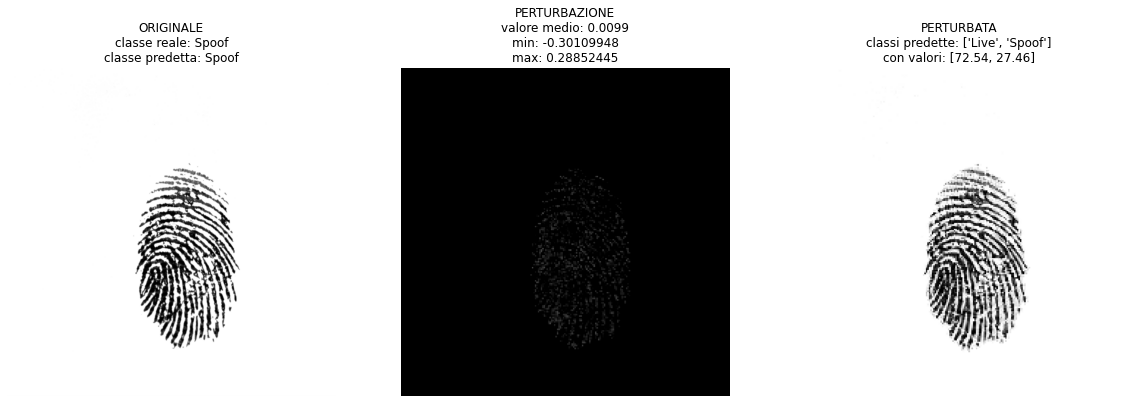

In [32]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_,_=test_average(classifier,input)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
preds_orig=preds_orig[list_print]
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv)

#salvataggio e lettura immagine

In [33]:
save_read(x_print_adv[0])

valori img originale:
(0, array([0.7254052 , 0.27459478], dtype=float32), [0.7071058377623558, -0.2643281355500221])
valori dopo salvataggio/lettura:
(0, array([0.71716136, 0.2828386 ], dtype=float32), [0.68645970672369, -0.2439647227525711])
